## Problem 2

In [413]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import linregress
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def GenBA(N, m):
    if m > 1:
        G = nx.complete_graph(m)
        t = m+1
    else:
        G = nx.complete_graph(m+1)
        t = m+2
    while t <= N:
        degrees_from_G = list(G.degree())
        available_nodes = [t[0] for t in degrees_from_G]
        available_degrees = [t[1] for t in degrees_from_G]
        G.add_node(t)
        for _ in range(m):
            total_degree = sum(degrees for degrees in available_degrees)
            probabilities = [degree/total_degree for degree in available_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_degrees.pop(chosen_position)
        t += 1
            
    return G

In [123]:
def IntermediateGenBA(Ns, m):
    G_iter = nx.complete_graph(m)
    t = m+1
    Glist = []
    Nmax = max(Ns)
    while t <= Nmax:
        degrees_from_G = list(G_iter.degree())
        available_nodes = [t[0] for t in degrees_from_G]
        available_degrees = [t[1] for t in degrees_from_G]
        G_iter.add_node(t)
        for _ in range(m):
            total_degree = sum(degrees for degrees in available_degrees)
            probabilities = [degree/total_degree for degree in available_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G_iter.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_degrees.pop(chosen_position)
        if t in Ns:
            Glist.append(G_iter.copy())
        t += 1

    return Glist

In [124]:
def CalcDegreeDistribution(G):
    degree_sequence = [degree for node, degree in G.degree()]
    degree_count = {}
    for degree in degree_sequence:
        degree_count[degree] = degree_count.get(degree, 0) + 1

    total_nodes = len(degree_sequence)
    degrees = sorted(degree_count.keys())
    probabilities = [degree_count[degree] / total_nodes for degree in degrees]
    

    return degrees, probabilities

In [125]:
def LogBinDegreeDistribution(degrees_input, probabilities_input, bin_base=2):
    max_degree = max(degrees_input)
    bin_edges = []
    edge = 1
    while edge <= max_degree:
        bin_edges.append(edge)
        edge *= bin_base

    binned_degrees = []
    binned_probabilities = []
    for i in range(len(bin_edges) - 1):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i + 1]
        bin_degrees = [degree for degree in degrees_input if bin_start <= degree < bin_end]
        bin_probs = [probabilities_input[degrees_input.index(degree)] for degree in bin_degrees]

        if bin_degrees:
            middle_degree_position = (bin_end + bin_start)/2
            bin_range = bin_end - bin_start
            avg_probability = sum(bin_probs) / bin_range
            binned_degrees.append(middle_degree_position)
            binned_probabilities.append(avg_probability)

    return binned_degrees, binned_probabilities


In [131]:
N_configs = 6
Ns = [100, 1000, 10000]
m = 4
bin_base_size = np.pow(10, 1/10)

all_degrees = {N: [] for N in Ns}
all_probabilities = {N: [] for N in Ns}
all_binned_degrees = {N: [] for N in Ns}
all_binned_probabilities = {N: [] for N in Ns}

for config in range(N_configs):
    G_list = IntermediateGenBA(Ns, m)
    
    for idx, G in enumerate(G_list):
        degrees, probabilities = CalcDegreeDistribution(G)
        binned_degrees, binned_probabilities = LogBinDegreeDistribution(degrees, probabilities, bin_base=bin_base_size)
        
        all_degrees[Ns[idx]].append(degrees)
        all_probabilities[Ns[idx]].append(probabilities)
        all_binned_degrees[Ns[idx]].append(binned_degrees)
        all_binned_probabilities[Ns[idx]].append(binned_probabilities)

In [162]:
degrees_list = []
probabilities_list = []
binned_degrees_list = []
binned_probabilities_list = []

for N in Ns:
    all_unique_degrees = sorted(set(deg for config_degrees in all_degrees[N] for deg in config_degrees))
    
    avg_unbinned_probs = []
    for degree in all_unique_degrees:
        prob_sum = 0
        count = 0
        for config_degrees, config_probs in zip(all_degrees[N], all_probabilities[N]):
            if degree in config_degrees:
                idx = config_degrees.index(degree)
                prob_sum += config_probs[idx]
                count += 1
        avg_unbinned_probs.append(prob_sum / N_configs if count > 0 else 0)
    
    degrees_list.append(all_unique_degrees)
    probabilities_list.append(avg_unbinned_probs)
    
    ref_degrees = all_binned_degrees[N][0]
    
    avg_binned_probs = []
    for bin_idx in range(len(ref_degrees)):
        prob_sum = 0
        count = 0
        for config_probs in all_binned_probabilities[N]:
            if bin_idx < len(config_probs):
                prob_sum += config_probs[bin_idx]
                count += 1
        avg_binned_probs.append(prob_sum / N_configs if count > 0 else 0)
    
    binned_degrees_list.append(ref_degrees)
    binned_probabilities_list.append(avg_binned_probs)


In [163]:
log_degrees_list = []
log_probabilities_list = []
log_binned_degrees_list = []
log_binned_probabilities_list = []

for degrees, probabilities in zip(degrees_list, probabilities_list):
    log_degrees = [np.log10(d) if d > 0 else np.nan for d in degrees]
    log_probs = [np.log10(p) if p > 0 else np.nan for p in probabilities]
    log_degrees_list.append(log_degrees)
    log_probabilities_list.append(log_probs)

for binned_degrees, binned_probabilities in zip(binned_degrees_list, binned_probabilities_list):
    log_binned_deg = [np.log10(d) if d > 0 else np.nan for d in binned_degrees]
    log_binned_prob = [np.log10(p) if p > 0 else np.nan for p in binned_probabilities]
    log_binned_degrees_list.append(log_binned_deg)
    log_binned_probabilities_list.append(log_binned_prob)


In [181]:
fit_results = []
fit_lines_x = []
fit_lines_y = []
fit_ranges = [(0.5, 2.75), (0.5, 2.75), (0.5, 2.75)]  # Adjust as needed for each N

for idx, (log_binned_degrees, log_binned_probabilities) in enumerate(zip(log_binned_degrees_list, log_binned_probabilities_list)):
    
    x = np.array(log_binned_degrees)
    y = np.array(log_binned_probabilities)
    mask = (~np.isnan(x)) & (~np.isnan(y)) & (x >= fit_ranges[idx][0]) & (x <= fit_ranges[idx][1])
    x_fit = x[mask]
    y_fit = y[mask]
    slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
    fit_results.append({'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err})
    
    fit_x = np.linspace(fit_ranges[idx][0], fit_ranges[idx][1], 100)
    fit_y = slope * fit_x + intercept
    fit_lines_x.append(fit_x)
    fit_lines_y.append(fit_y)

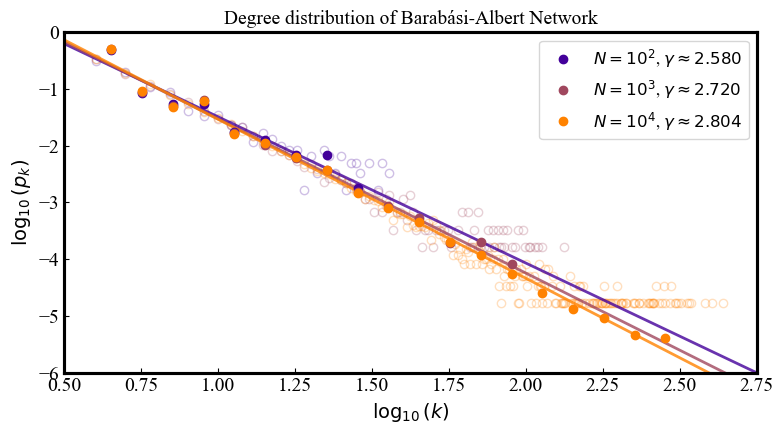

In [185]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

colors = ['#43009a', '#a0475e', '#ff8200']
labels = []
for idx, N in enumerate(Ns):
    gamma = -fit_results[idx]['slope'] if idx < len(fit_results) else None
    if gamma is not None:
        labels.append(fr'$N = 10^{{{int(np.log10(N))}}}$, $\gamma \approx {gamma:.3f}$')
    else:
        labels.append(fr'$N = 10^{{{int(np.log10(N))}}}$')

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axgrid[0, 0])

for (log_degrees, log_probabilities), color in zip(zip(log_degrees_list, log_probabilities_list), colors):
    ax.plot(log_degrees, log_probabilities, color=color, marker="o", linestyle='None', 
              markerfacecolor='none', markeredgecolor=color, alpha=0.25)
    
for fit_x, fit_y, color in zip(fit_lines_x, fit_lines_y, colors):
    ax.plot(fit_x, fit_y, color=color, linestyle='-', linewidth=2, alpha=0.8)

for (log_binned_degrees, log_binned_probabilities), color, label in zip(zip(log_binned_degrees_list, log_binned_probabilities_list), colors, labels):
    ax.plot(log_binned_degrees, log_binned_probabilities, color=color, marker="o", linestyle='None', 
              markerfacecolor=color, markeredgecolor=color, alpha=1, label=label)

ax.set_title("Degree distribution of Barabási-Albert Network")
ax.set_ylabel(r"$\log_{10}(p_{k})$")
ax.set_xlabel(r"$\log_{10}(k)$")
ax.legend()

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

ax.set_xlim(0.5, 2.75)
ax.set_ylim(-6, 0)

fig.tight_layout()
plt.savefig('a2_problem_2_ab.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [186]:
cumulative_probabilities_list = []
log_cumulative_degrees_list = []
log_cumulative_probabilities_list = []

for degrees, probabilities in zip(degrees_list, probabilities_list):
    degrees = np.array(degrees)
    probabilities = np.array(probabilities)
    sort_idx = np.argsort(degrees)
    degrees_sorted = degrees[sort_idx]
    probabilities_sorted = probabilities[sort_idx]

    cumulative_probs = np.cumsum(probabilities_sorted[::-1])[::-1]
    cumulative_probabilities_list.append(cumulative_probs)
    
    log_degrees = [np.log10(d) if d > 0 else np.nan for d in degrees_sorted]
    log_cum_probs = [np.log10(p) if p > 0 else np.nan for p in cumulative_probs]
    log_cumulative_degrees_list.append(log_degrees)
    log_cumulative_probabilities_list.append(log_cum_probs)

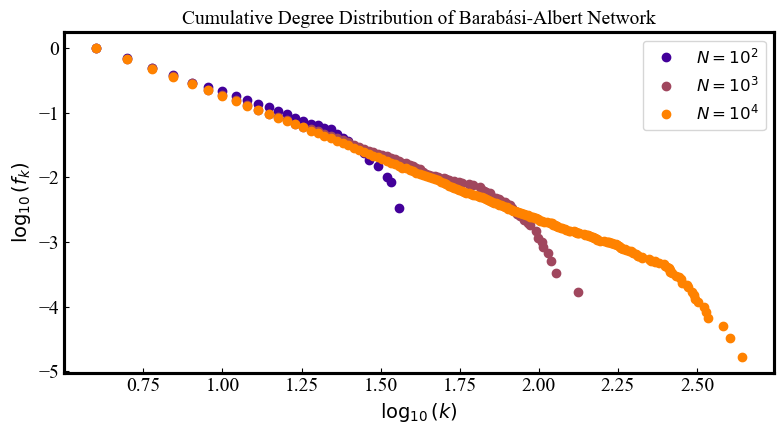

In [338]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

colors = ['#43009a', '#a0475e', '#ff8200']
labels = [fr'$N = 10^{{{int(np.log10(N))}}}$' for N in Ns]

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axgrid[0, 0])

for log_degrees, log_cum_probs, color, label in zip(log_cumulative_degrees_list, log_cumulative_probabilities_list, colors, labels):
    ax.plot(log_degrees, log_cum_probs, color=color, marker="o", linestyle='None', markerfacecolor=color, markeredgecolor=color, alpha=1, label=label)

ax.set_title("Cumulative Degree Distribution of Barabási-Albert Network")
ax.set_ylabel(r"$\log_{10}(f_{k})$")
ax.set_xlabel(r"$\log_{10}(k)$")
ax.legend()

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

#ax.set_xlim(0.5, 2.75)
#ax.set_ylim(-5, .2)

fig.tight_layout()
plt.savefig('a2_problem_2_c.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [200]:
def ClusteringGenBA(N, m):
    G = nx.complete_graph(m)
    t = m+1
    time_list = []
    clustering_list = []
    while t <= N:
        degrees_from_G = list(G.degree())
        available_nodes = [t[0] for t in degrees_from_G]
        available_degrees = [t[1] for t in degrees_from_G]
        G.add_node(t)
        for _ in range(m):
            total_degree = sum(degrees for degrees in available_degrees)
            probabilities = [degree/total_degree for degree in available_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_degrees.pop(chosen_position)
        time_list.append(t)
        clustering_list.append( nx.average_clustering(G) )
        t += 1
            
    return time_list , clustering_list

In [ ]:
N = 1000
m = 4
n_configs = 6
clustering_times = None
clustering_values_accum = None
for config in range(n_configs):
    times, values = ClusteringGenBA(N, m)
    if clustering_times is None:
        clustering_times = times
        clustering_values_accum = np.array(values)
    else:
        clustering_values_accum += np.array(values)
clustering_values = clustering_values_accum / n_configs


clustering_times_big_N = [t for t in clustering_times if t > 100]
clustering_values_big_N = [v for t, v in zip(clustering_times, clustering_values) if t > 100]

In [336]:
lnN_squared_over_N_list = [ (np.log(t)**2)/t for t in clustering_times ]
lnN_squared_over_N_for_big_N_list = [ (np.log(t)**2)/t for t in clustering_times_big_N ]

In [355]:
x_fit = np.array(lnN_squared_over_N_for_big_N_list)
y_fit = np.array(clustering_values_big_N)
mask = (~np.isnan(x_fit)) & (~np.isnan(y_fit))
x_fit = x_fit[mask]
y_fit = y_fit[mask]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
fit_x = np.linspace(min(x_fit), max(x_fit), 100)
fit_y = slope * fit_x + intercept

/var/folders/1n/rqr82kgs60s4205zxs_lb3t00000gn/T/ipykernel_98974/2201815343.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


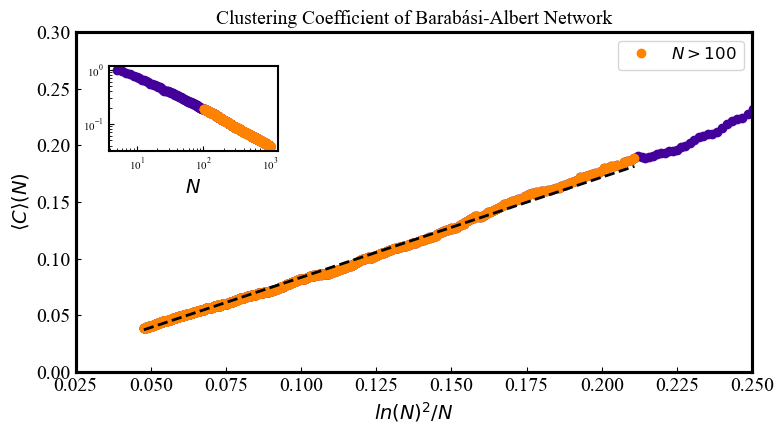

In [372]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axgrid[0, 0])

ax.plot(lnN_squared_over_N_list, clustering_values, color='#43009a', marker="o", linestyle='None', markerfacecolor='#43009a', markeredgecolor='#43009a', alpha=1)
ax.plot(lnN_squared_over_N_for_big_N_list, clustering_values_big_N, color='#ff8200', marker="o", linestyle='None', markerfacecolor='#ff8200', markeredgecolor='#ff8200', alpha=1, label=r'$N > 100$')

# Fit a line to the filtered data
from scipy.stats import linregress
x_fit = np.array(lnN_squared_over_N_for_big_N_list)
y_fit = np.array(clustering_values_big_N)
mask = (~np.isnan(x_fit)) & (~np.isnan(y_fit))
x_fit = x_fit[mask]
y_fit = y_fit[mask]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
fit_x = np.linspace(min(x_fit), max(x_fit), 100)
fit_y = slope * fit_x + intercept
#ax.plot(fit_x, fit_y, color='black', linestyle='--', linewidth=2, label=f'Fit: slope={slope:.3f}, intercept={intercept:.3f}')
ax.plot(fit_x, fit_y, color='black', linestyle='--', linewidth=2)

ax.set_title("Clustering Coefficient of Barabási-Albert Network")
ax.set_ylabel(r"$\left<C\right>(N)$")
ax.set_xlabel(r"$ln(N)^2/N$")

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

ax.set_xlim(0.025, 0.25)
ax.set_ylim(0, 0.3)

axins = inset_axes(ax, width="25%", height="25%", loc='upper left', borderpad=2)
axins.loglog(clustering_times, clustering_values, color='#43009a', marker="o", linestyle='None', markerfacecolor='#43009a', markeredgecolor='#43009a', alpha=1, label='All N')
axins.loglog(clustering_times_big_N, clustering_values_big_N, color='#ff8200', marker="o", linestyle='None', markerfacecolor='#ff8200', markeredgecolor='#ff8200', alpha=1, label='N > 100')
axins.set_xlabel(r"$N$")
axins.tick_params(direction='in', which='both', labelsize=8)
for spine in axins.spines.values():
    spine.set_linewidth(1.5)
#axins.legend(fontsize=7)

ax.legend()
fig.tight_layout()
plt.savefig('a2_problem_2_d.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
def FollowGenBA(tinitials, tmax, m):
    G_iter = nx.complete_graph(m)
    t = m+1
    tlist_list = [[] for _ in tinitials]
    klist_list = [[] for _ in tinitials]
    while t <= tmax:
        degrees_from_G = list(G_iter.degree())
        available_nodes = [t[0] for t in degrees_from_G]
        available_degrees = [t[1] for t in degrees_from_G]
        G_iter.add_node(t)
        for _ in range(m):
            total_degree = sum(degrees for degrees in available_degrees)
            probabilities = [degree/total_degree for degree in available_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G_iter.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_degrees.pop(chosen_position)
        for idx, tinitial in enumerate(tinitials):
            if t >= tinitial:
                tlist_list[idx].append(t)
                klist_list[idx].append(G_iter.degree(tinitial))
        t += 1

    return tlist_list, klist_list

In [45]:
tinitials = [100, 1000, 5000]
n_configs = 6
all_degrees_list = [[] for _ in tinitials]

for config in range(n_configs):
    tlist_list, klist_list = FollowGenBA(tinitials, 10000, 4)
    for idx in range(len(tinitials)):
        all_degrees_list[idx].append(klist_list[idx])

avg_degrees_list = []
for idx in range(len(tinitials)):
    avg_degrees = np.mean(all_degrees_list[idx], axis=0)
    avg_degrees_list.append(avg_degrees)

t_sqrt_list = []
for idx in range(len(tinitials)):
    times = tlist_list[idx]
    t_sqrt = [np.power(t, 0.5) for t in times]
    t_sqrt_list.append(t_sqrt)

In [47]:
# Fit straight lines for each tinitial
fit_results_list = []
fit_lines_sqrt_x = []
fit_lines_y = []

for idx in range(len(tinitials)):
    x = np.array(t_sqrt_list[idx])
    y = np.array(avg_degrees_list[idx])
    
    # Remove any NaN values
    mask = (~np.isnan(x)) & (~np.isnan(y))
    x_fit = x[mask]
    y_fit = y[mask]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
    fit_results_list.append({'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err})
    
    # Generate fit line
    fit_x = np.linspace(min(x_fit), max(x_fit), 100)
    fit_y = slope * fit_x + intercept
    fit_lines_sqrt_x.append(fit_x)
    fit_lines_y.append(fit_y)

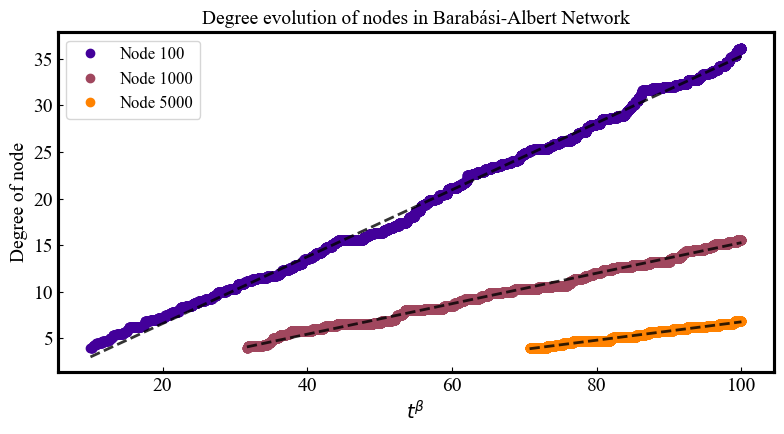

In [50]:
# Plot for each tinitial
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)
ax = fig.add_subplot(axgrid[0, 0])

colors = ['#43009a', '#a0475e', '#ff8200']

for idx, ti in enumerate(tinitials):
    times = t_sqrt_list[idx]
    ax.plot(times, avg_degrees_list[idx], color=colors[idx % len(colors)], marker="o", linestyle='None', 
            markerfacecolor=colors[idx % len(colors)], markeredgecolor=colors[idx % len(colors)], 
            alpha=1, label=f'Node {ti}')

# Add fitted lines
for idx, (fit_x, fit_y) in enumerate(zip(fit_lines_sqrt_x, fit_lines_y)):
    ax.plot(fit_x, fit_y, color='black', linestyle='--', linewidth=2, alpha=0.8)

ax.set_title("Degree evolution of nodes in Barabási-Albert Network")
ax.set_ylabel(r"Degree of node")
ax.set_xlabel(r"$t^{\beta}$")

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

if len(tinitials) > 1:
    ax.legend()

fig.tight_layout()
plt.savefig('a2_problem_2_e.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Problem 3

In [52]:
def GenBBUniform(N, m):
    G = nx.complete_graph(m)
    for node in G.nodes():
        G.nodes[node]['fitness'] = np.random.uniform(0, 1)
    t = m+1
    while t <= N:
        degrees_from_G = list(G.degree())
        fitness_from_G = list(nx.get_node_attributes(G, 'fitness').values())
        available_nodes = [t[0] for t in degrees_from_G]
        available_fitness_degrees = [ fitness_from_G[i] * t[1] for i, t in enumerate(degrees_from_G)]
        G.add_node(t)
        G.nodes[t]['fitness'] = np.random.uniform(0, 1)
        for _ in range(m):
            total_fitness_degree = sum(fitness_degrees for fitness_degrees in available_fitness_degrees)
            probabilities = [fitness_degrees/total_fitness_degree for fitness_degrees in available_fitness_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_fitness_degrees.pop(chosen_position)
        t += 1
            
    return G

def GenBBSpike(N, m):
    G = nx.complete_graph(m)
    for node in G.nodes():
        G.nodes[node]['fitness'] = 0.1 if np.random.random() < 0.9 else 0.9
    t = m+1
    while t <= N:
        degrees_from_G = list(G.degree())
        fitness_from_G = list(nx.get_node_attributes(G, 'fitness').values())
        available_nodes = [t[0] for t in degrees_from_G]
        available_fitness_degrees = [ fitness_from_G[i] * t[1] for i, t in enumerate(degrees_from_G)]
        G.add_node(t)
        G.nodes[t]['fitness'] = 0.1 if np.random.random() < 0.9 else 0.9
        for _ in range(m):
            total_fitness_degree = sum(fitness_degrees for fitness_degrees in available_fitness_degrees)
            probabilities = [fitness_degrees/total_fitness_degree for fitness_degrees in available_fitness_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_fitness_degrees.pop(chosen_position)
        t += 1
            
    return G

In [61]:
N = 10000
m = 4
N_configs = 6
bin_base_size = np.pow(10, 1/10)

In [62]:
all_degrees_uniform = []
all_probabilities_uniform = []
all_binned_degrees_uniform = []
all_binned_probabilities_uniform = []

for config in range(N_configs):
    G = GenBBUniform(N, m)
    degrees, probabilities = CalcDegreeDistribution(G)
    binned_degrees, binned_probabilities = LogBinDegreeDistribution(degrees, probabilities, bin_base=bin_base_size)
    
    all_degrees_uniform.append(degrees)
    all_probabilities_uniform.append(probabilities)
    all_binned_degrees_uniform.append(binned_degrees)
    all_binned_probabilities_uniform.append(binned_probabilities)

In [63]:
all_unique_degrees_uniform = sorted(set(deg for config_degrees in all_degrees_uniform for deg in config_degrees))
avg_unbinned_probs_uniform = []
for degree in all_unique_degrees_uniform:
    prob_sum = 0
    count = 0
    for config_degrees, config_probs in zip(all_degrees_uniform, all_probabilities_uniform):
        if degree in config_degrees:
            idx = config_degrees.index(degree)
            prob_sum += config_probs[idx]
            count += 1
    avg_unbinned_probs_uniform.append(prob_sum / N_configs if count > 0 else 0)

ref_degrees_uniform = all_binned_degrees_uniform[0]
avg_binned_probs_uniform = []
for bin_idx in range(len(ref_degrees_uniform)):
    prob_sum = 0
    count = 0
    for config_probs in all_binned_probabilities_uniform:
        if bin_idx < len(config_probs):
            prob_sum += config_probs[bin_idx]
            count += 1
    avg_binned_probs_uniform.append(prob_sum / N_configs if count > 0 else 0)

In [64]:
all_degrees_spike = []
all_probabilities_spike = []
all_binned_degrees_spike = []
all_binned_probabilities_spike = []

for config in range(N_configs):
    G = GenBBSpike(N, m)
    degrees, probabilities = CalcDegreeDistribution(G)
    binned_degrees, binned_probabilities = LogBinDegreeDistribution(degrees, probabilities, bin_base=bin_base_size)
    
    all_degrees_spike.append(degrees)
    all_probabilities_spike.append(probabilities)
    all_binned_degrees_spike.append(binned_degrees)
    all_binned_probabilities_spike.append(binned_probabilities)

In [65]:
all_unique_degrees_spike = sorted(set(deg for config_degrees in all_degrees_spike for deg in config_degrees))
avg_unbinned_probs_spike = []
for degree in all_unique_degrees_spike:
    prob_sum = 0
    count = 0
    for config_degrees, config_probs in zip(all_degrees_spike, all_probabilities_spike):
        if degree in config_degrees:
            idx = config_degrees.index(degree)
            prob_sum += config_probs[idx]
            count += 1
    avg_unbinned_probs_spike.append(prob_sum / N_configs if count > 0 else 0)

ref_degrees_spike = all_binned_degrees_spike[0]
avg_binned_probs_spike = []
for bin_idx in range(len(ref_degrees_spike)):
    prob_sum = 0
    count = 0
    for config_probs in all_binned_probabilities_spike:
        if bin_idx < len(config_probs):
            prob_sum += config_probs[bin_idx]
            count += 1
    avg_binned_probs_spike.append(prob_sum / N_configs if count > 0 else 0)

In [66]:
log_degrees_uniform = [np.log10(d) if d > 0 else np.nan for d in all_unique_degrees_uniform]
log_probs_uniform = [np.log10(p) if p > 0 else np.nan for p in avg_unbinned_probs_uniform]
log_binned_deg_uniform = [np.log10(d) if d > 0 else np.nan for d in ref_degrees_uniform]
log_binned_prob_uniform = [np.log10(p) if p > 0 else np.nan for p in avg_binned_probs_uniform]

log_degrees_spike = [np.log10(d) if d > 0 else np.nan for d in all_unique_degrees_spike]
log_probs_spike = [np.log10(p) if p > 0 else np.nan for p in avg_unbinned_probs_spike]
log_binned_deg_spike = [np.log10(d) if d > 0 else np.nan for d in ref_degrees_spike]
log_binned_prob_spike = [np.log10(p) if p > 0 else np.nan for p in avg_binned_probs_spike]

In [71]:
max_degrees_uniform = [max(degrees) for degrees in all_degrees_uniform]
max_degrees_spike = [max(degrees) for degrees in all_degrees_spike]

avg_max_degree_uniform = np.mean(max_degrees_uniform)
avg_max_degree_spike = np.mean(max_degrees_spike)

In [183]:
from scipy.stats import linregress

# Fit in log space: log(p_k) = -gamma * log(k) - log(ln(k)) + A
# Rearranging: log(p_k) + log(ln(k)) = -gamma * log(k) + A

# Use the binned data
k_data = np.array(ref_degrees_uniform)
p_data = np.array(avg_binned_probs_uniform)

# Remove any zeros or invalid values
mask = (k_data > 1) & (p_data > 0)  # k > 1 to ensure ln(k) is defined
k_fit = k_data[mask]
p_fit = p_data[mask]

# Transform to log space
log_k = np.log10(k_fit)
log_p = np.log10(p_fit)
log_ln_k = np.log10(np.log(k_fit))  # log10(ln(k))

# Linear fit: (log_p + log_ln_k) = -gamma * log_k + A
y_transformed = log_p + log_ln_k
x_transformed = log_k

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_transformed, y_transformed)
gamma_fit = -slope
A_fit = intercept

# Generate fit curve for plotting
k_fit_curve = np.logspace(np.log10(min(k_fit)), np.log10(max(k_fit)), 100)
log_k_fit_curve = np.log10(k_fit_curve)
log_ln_k_fit_curve = np.log10(np.log(k_fit_curve))

# Calculate fitted y values: log(p_k) = -gamma * log(k) - log(ln(k)) + A
log_p_fit_curve = -gamma_fit * log_k_fit_curve - log_ln_k_fit_curve + A_fit

print(slope)


-2.221366409193182


In [172]:
from scipy.special import expi
from scipy.integrate import quad

# Parameters
C = 1.255  # You can adjust this value
m_param = 4  # Same as the m used in network generation

# Get kmin and kmax from the data
kmin = min(ref_degrees_uniform)
kmax = max(ref_degrees_uniform)

# Create k values (degree range) in log space
k_values = np.logspace(np.log10(m_param), np.log10(kmax), 10000)

# Calculate the unnormalized function: C * (k/m)^(-1) * Gamma(0, C*ln(k/m))
# Upper incomplete gamma function Γ(0, x) = -Ei(-x) for x > 0
ratio = k_values / m_param
log_ratio = np.log(ratio)

# Upper incomplete gamma function Γ(0, C*ln(k/m))
gamma_upper = -expi(-C * log_ratio)

# Unnormalized function
y_values_unnormalized = C * (1/ratio) * gamma_upper

# Define the function for numerical integration
def integrand(k):
    ratio_int = k / m_param
    log_ratio_int = np.log(ratio_int)
    gamma_upper_int = -expi(-C * log_ratio_int)
    return C * (1/ratio_int) * gamma_upper_int

# Compute normalization constant by integrating from kmin to kmax
normalization_constant, error = quad(integrand, kmin, kmax)

# Apply normalization
y_values = y_values_unnormalized / normalization_constant

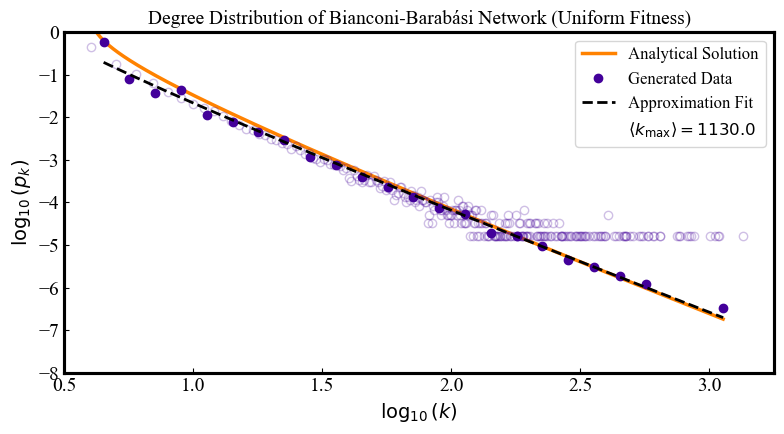

In [182]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)
ax = fig.add_subplot(axgrid[0, 0])

colors = ['#43009a', '#ff8200']
label_uniform = 'Generated Data'


log_k_gamma = np.log10(k_values)
log_y_gamma = np.log10(y_values)
ax.plot(log_k_gamma, log_y_gamma, color='#ff8200', linestyle='-', linewidth=2.5, 
        label=fr'Analytical Solution')


ax.plot(log_degrees_uniform, log_probs_uniform, color=colors[0], marker="o", linestyle='None', 
          markerfacecolor='none', markeredgecolor=colors[0], alpha=0.25)


ax.plot(log_binned_deg_uniform, log_binned_prob_uniform, color=colors[0], marker="o", linestyle='None', 
          markerfacecolor=colors[0], markeredgecolor=colors[0], alpha=1, label=label_uniform)


ax.plot(log_k_fit_curve, log_p_fit_curve, color='black', linestyle='--', linewidth=2, 
        label=fr'Approximation Fit')

# Add invisible line for kmax in legend
ax.plot([], [], ' ', label=fr'$\langle k_{{\max}} \rangle = {avg_max_degree_uniform:.1f}$')

ax.set_title("Degree Distribution of Bianconi-Barabási Network (Uniform Fitness)")
ax.set_ylabel(r"$\log_{10}(p_{k})$")
ax.set_xlabel(r"$\log_{10}(k)$")
ax.legend()

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

ax.set_xlim(0.5, 3.25)
ax.set_ylim(-8, 0)

fig.tight_layout()
plt.savefig('a2_problem_3_b1.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [185]:
x_spike = np.array(log_binned_deg_spike)
y_spike = np.array(log_binned_prob_spike)
mask_spike = (~np.isnan(x_spike)) & (~np.isnan(y_spike))
x_fit_spike = x_spike[mask_spike]
y_fit_spike = y_spike[mask_spike]

slope_spike, intercept_spike, r_value_spike, p_value_spike, std_err_spike = linregress(x_fit_spike, y_fit_spike)
gamma_spike = -slope_spike

# Generate fit line
fit_x_spike = np.linspace(min(x_fit_spike), max(x_fit_spike), 100)
fit_y_spike = slope_spike * fit_x_spike + intercept_spike

print(slope_spike)

-2.0489979319412903


In [176]:
from scipy.integrate import quad

m_param = 4

# Get kmin and kmax from the spike data
kmin_spike = min(ref_degrees_spike)
kmax_spike = max(ref_degrees_spike)

k_analytical = np.logspace(np.log10(m_param), np.log10(kmax_spike), 10000)
ratio_analytical = k_analytical / m_param

# Unnormalized analytical function
p_analytical_spike_unnormalized = 9 * ratio_analytical**(-11) + (1/9) * ratio_analytical**(-1.9/0.9)

# Define the function for numerical integration
def integrand_spike(k):
    ratio_int = k / m_param
    return 9 * ratio_int**(-11) + (1/9) * ratio_int**(-1.9/0.9)

# Compute normalization constant by integrating from kmin to kmax
normalization_constant_spike, error_spike = quad(integrand_spike, kmin_spike, kmax_spike)

# Apply normalization
p_analytical_spike = p_analytical_spike_unnormalized / normalization_constant_spike
log_k_analytical_spike = np.log10(k_analytical)
log_p_analytical_spike = np.log10(p_analytical_spike)

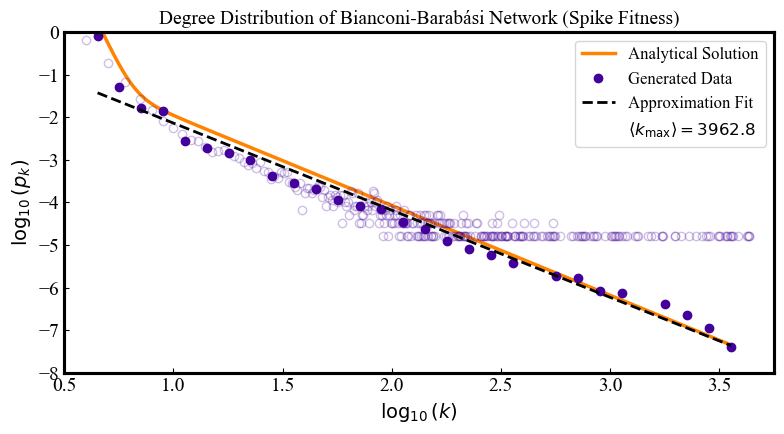

In [181]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)
ax = fig.add_subplot(axgrid[0, 0])

colors = ['#43009a', '#ff8200']
label = 'Generated Data'

ax.plot(log_k_analytical_spike, log_p_analytical_spike, color=colors[1], linestyle='-', linewidth=2.5,
        label=r'Analytical Solution')

ax.plot(log_degrees_spike, log_probs_spike, color=colors[0], marker="o", linestyle='None', 
          markerfacecolor='none', markeredgecolor=colors[0], alpha=0.25)

ax.plot(log_binned_deg_spike, log_binned_prob_spike, color=colors[0], marker="o", linestyle='None', 
          markerfacecolor=colors[0], markeredgecolor=colors[0], alpha=1, label=label)

ax.plot(fit_x_spike, fit_y_spike, color='black', linestyle='--', linewidth=2, 
        label=fr'Approximation Fit')

# Add invisible line for kmax in legend
ax.plot([], [], ' ', label=fr'$\langle k_{{\max}} \rangle = {avg_max_degree_spike:.1f}$')

ax.set_title("Degree Distribution of Bianconi-Barabási Network (Spike Fitness)")
ax.set_ylabel(r"$\log_{10}(p_{k})$")
ax.set_xlabel(r"$\log_{10}(k)$")
ax.legend()

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

ax.set_xlim(0.5, 3.75)
ax.set_ylim(-8, 0)

fig.tight_layout()
plt.savefig('a2_problem_3_b2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [187]:
def ClusteringGenBBUniform(N, m):
    G = nx.complete_graph(m)
    for node in G.nodes():
        G.nodes[node]['fitness'] = np.random.uniform(0, 1)
    t = m+1
    time_list = []
    clustering_list = []
    while t <= N:
        degrees_from_G = list(G.degree())
        fitness_from_G = list(nx.get_node_attributes(G, 'fitness').values())
        available_nodes = [t[0] for t in degrees_from_G]
        available_fitness_degrees = [ fitness_from_G[i] * t[1] for i, t in enumerate(degrees_from_G)]
        G.add_node(t)
        G.nodes[t]['fitness'] = np.random.uniform(0, 1)
        for _ in range(m):
            total_fitness_degree = sum(fitness_degrees for fitness_degrees in available_fitness_degrees)
            probabilities = [fitness_degrees/total_fitness_degree for fitness_degrees in available_fitness_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_fitness_degrees.pop(chosen_position)
        time_list.append(t)
        clustering_list.append( nx.average_clustering(G) )
        t += 1

    return time_list, clustering_list

def ClusteringGenBBSpike(N, m):
    G = nx.complete_graph(m)
    for node in G.nodes():
        G.nodes[node]['fitness'] = 0.1 if np.random.random() < 0.9 else 0.9
    t = m+1
    time_list = []
    clustering_list = []
    while t <= N:
        degrees_from_G = list(G.degree())
        fitness_from_G = list(nx.get_node_attributes(G, 'fitness').values())
        available_nodes = [t[0] for t in degrees_from_G]
        available_fitness_degrees = [ fitness_from_G[i] * t[1] for i, t in enumerate(degrees_from_G)]
        G.add_node(t)
        G.nodes[t]['fitness'] = 0.1 if np.random.random() < 0.9 else 0.9
        for _ in range(m):
            total_fitness_degree = sum(fitness_degrees for fitness_degrees in available_fitness_degrees)
            probabilities = [fitness_degrees/total_fitness_degree for fitness_degrees in available_fitness_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_fitness_degrees.pop(chosen_position)
        time_list.append(t)
        clustering_list.append( nx.average_clustering(G) )
        t += 1

    return time_list, clustering_list

In [188]:
N = 1000
m = 4
n_configs = 6
uniform_clustering_times = None
uniform_clustering_values_accum = None
for config in range(n_configs):
    times, values = ClusteringGenBBUniform(N, m)
    if uniform_clustering_times is None:
        uniform_clustering_times = times
        uniform_clustering_values_accum = np.array(values)
    else:
        uniform_clustering_values_accum += np.array(values)
uniform_clustering_values = uniform_clustering_values_accum / n_configs


uniform_clustering_times_big_N = [t for t in uniform_clustering_times if t > 100]
uniform_clustering_values_big_N = [v for t, v in zip(uniform_clustering_times, uniform_clustering_values) if t > 100]

In [ ]:
spiked_clustering_times = None
spiked_clustering_values_accum = None
for config in range(n_configs):
    times, values = ClusteringGenBBSpike(N, m)
    if spiked_clustering_times is None:
        spiked_clustering_times = times
        spiked_clustering_values_accum = np.array(values)
    else:
        spiked_clustering_values_accum += np.array(values)
spiked_clustering_values = spiked_clustering_values_accum / n_configs


spiked_clustering_times_big_N = [t for t in spiked_clustering_times if t > 100]
spiked_clustering_values_big_N = [v for t, v in zip(spiked_clustering_times, spiked_clustering_values) if t > 100]

In [210]:
# Log binning function for clustering data
def LogBinClustering(times_input, values_input, bin_base=2):
    max_time = max(times_input)
    min_time = min(times_input)
    
    # Create bin edges
    bin_edges = []
    edge = min_time
    while edge <= max_time:
        bin_edges.append(edge)
        edge *= bin_base
    if bin_edges[-1] < max_time:
        bin_edges.append(max_time * bin_base)
    
    binned_times = []
    binned_values = []
    
    for i in range(len(bin_edges) - 1):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i + 1]
        
        # Find values in this bin
        bin_indices = [idx for idx, t in enumerate(times_input) if bin_start <= t < bin_end]
        
        if bin_indices:
            # Use geometric mean for time (appropriate for log scale)
            bin_times = [times_input[idx] for idx in bin_indices]
            bin_vals = [values_input[idx] for idx in bin_indices]
            
            # Geometric mean for time, arithmetic mean for clustering coefficient
            binned_time = np.exp(np.mean([np.log(t) for t in bin_times]))
            binned_value = np.mean(bin_vals)
            
            binned_times.append(binned_time)
            binned_values.append(binned_value)
    
    return binned_times, binned_values

# Apply log binning to uniform fitness clustering data
bin_base_clustering = 1.2
uniform_binned_times, uniform_binned_values = LogBinClustering(
    uniform_clustering_times, 
    uniform_clustering_values.tolist(), 
    bin_base=bin_base_clustering
)

# Apply log binning to spike fitness clustering data
spiked_binned_times, spiked_binned_values = LogBinClustering(
    spiked_clustering_times, 
    spiked_clustering_values.tolist(), 
    bin_base=bin_base_clustering
)

In [215]:
log_uniform_times = [np.log10(t) for t in uniform_clustering_times]
log_uniform_values = [np.log10(v) if v > 0 else np.nan for v in uniform_clustering_values]
log_spiked_times = [np.log10(t) for t in spiked_clustering_times]
log_spiked_values = [np.log10(v) if v > 0 else np.nan for v in spiked_clustering_values]

log_uniform_binned_times = [np.log10(t) for t in uniform_binned_times]
log_uniform_binned_values = [np.log10(v) if v > 0 else np.nan for v in uniform_binned_values]
log_spiked_binned_times = [np.log10(t) for t in spiked_binned_times]
log_spiked_binned_values = [np.log10(v) if v > 0 else np.nan for v in spiked_binned_values]

In [224]:
# Linear fit for uniform clustering data in log-log space
x_uniform_fit = np.array(log_uniform_binned_times)
y_uniform_fit = np.array(log_uniform_binned_values)

# Remove any NaN values
mask_uniform_fit = (~np.isnan(x_uniform_fit)) & (~np.isnan(y_uniform_fit))
x_uniform_fit = x_uniform_fit[mask_uniform_fit]
y_uniform_fit = y_uniform_fit[mask_uniform_fit]

# Perform linear regression
slope_uniform_clustering, intercept_uniform_clustering, r_value_uniform_clustering, p_value_uniform_clustering, std_err_uniform_clustering = linregress(x_uniform_fit, y_uniform_fit)

# Generate fit line
fit_x_uniform_clustering = np.linspace(min(x_uniform_fit), max(x_uniform_fit), 100)
fit_y_uniform_clustering = slope_uniform_clustering * fit_x_uniform_clustering + intercept_uniform_clustering

print(slope_uniform_clustering)

-0.42794378857461646


/var/folders/1n/rqr82kgs60s4205zxs_lb3t00000gn/T/ipykernel_18660/890676995.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


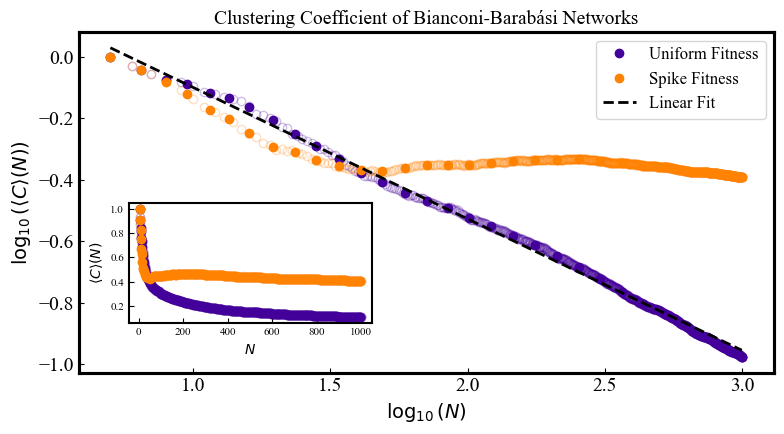

In [223]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

colors = ['#43009a', '#ff8200']

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)

ax = fig.add_subplot(axgrid[0, 0])

# Plot raw uniform fitness clustering data (semi-transparent)
ax.plot(log_uniform_times, log_uniform_values, color=colors[0], marker="o", 
        linestyle='None', markerfacecolor='none', markeredgecolor=colors[0], 
        alpha=0.25)

# Plot raw spiked fitness clustering data (semi-transparent)
ax.plot(log_spiked_times, log_spiked_values, color=colors[1], marker="o",
        linestyle='None', markerfacecolor='none', markeredgecolor=colors[1], 
        alpha=0.25)

# Plot binned uniform fitness clustering data (solid)
ax.plot(log_uniform_binned_times, log_uniform_binned_values, color=colors[0], marker="o", 
        linestyle='None', markerfacecolor=colors[0], markeredgecolor=colors[0], 
        alpha=1, label='Uniform Fitness')

# Plot binned spiked fitness clustering data (solid)
ax.plot(log_spiked_binned_times, log_spiked_binned_values, color=colors[1], marker="o",
        linestyle='None', markerfacecolor=colors[1], markeredgecolor=colors[1], 
        alpha=1, label='Spike Fitness')

# Add linear fit line for uniform data
ax.plot(fit_x_uniform_clustering, fit_y_uniform_clustering, color='black', linestyle='--', 
        linewidth=2, label=f'Linear Fit')

ax.set_title("Clustering Coefficient of Bianconi-Barabási Networks")
ax.set_ylabel(r"$\log_{10}(\left<C\right>(N))$")
ax.set_xlabel(r"$\log_{10}(N)$")

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

# Add linear inset
axins = inset_axes(ax, width="35%", height="35%", loc='lower left', borderpad=3)
axins.plot(uniform_clustering_times, uniform_clustering_values, color=colors[0], marker="o", 
             linestyle='None', markerfacecolor='none', markeredgecolor=colors[0], 
             alpha=0.25)
axins.plot(spiked_clustering_times, spiked_clustering_values, color=colors[1], marker="o", 
             linestyle='None', markerfacecolor='none', markeredgecolor=colors[1], 
             alpha=0.25)
axins.plot(uniform_binned_times, uniform_binned_values, color=colors[0], marker="o", 
             linestyle='None', markerfacecolor=colors[0], markeredgecolor=colors[0], 
             alpha=1)
axins.plot(spiked_binned_times, spiked_binned_values, color=colors[1], marker="o", 
             linestyle='None', markerfacecolor=colors[1], markeredgecolor=colors[1], 
             alpha=1)
axins.set_xlabel(r"$N$", fontsize=10)
axins.set_ylabel(r"$\left<C\right>(N)$", fontsize=10)
axins.tick_params(direction='in', which='both', labelsize=8)
for spine in axins.spines.values():
    spine.set_linewidth(1.5)

ax.legend()
fig.tight_layout()
plt.savefig('a2_problem_3_c.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [274]:
def FollowGenBBUniform(tinitials, tpickmin, tpickmax, tmax, m):
    G = nx.complete_graph(m)
    for node in G.nodes():
        G.nodes[node]['fitness'] = np.random.uniform(0, 1)
    t = m+1
    
    tlist_list = [[] for _ in range(len(tinitials) + 3)]
    klist_list = [[] for _ in range(len(tinitials) + 3)]
    
    top_fitness_nodes = []
    node_to_list_idx = {}  # Map node_id to its tracking list index
    
    while t <= tmax:
        degrees_from_G = list(G.degree())
        fitness_from_G = list(nx.get_node_attributes(G, 'fitness').values())
        available_nodes = [t[0] for t in degrees_from_G]
        available_fitness_degrees = [ fitness_from_G[i] * t[1] for i, t in enumerate(degrees_from_G)]
        G.add_node(t)
        new_fitness = np.random.uniform(0, 1)
        G.nodes[t]['fitness'] = new_fitness
        
        # Track highest fitness nodes added between tpickmin and tpickmax
        if tpickmin <= t <= tpickmax:
            if len(top_fitness_nodes) < 3:
                # Add new node and assign it to the next available slot
                slot_idx = len(top_fitness_nodes)
                top_fitness_nodes.append((t, new_fitness))
                node_to_list_idx[t] = len(tinitials) + slot_idx
                top_fitness_nodes.sort(key=lambda x: x[1], reverse=True)
            elif new_fitness > top_fitness_nodes[-1][1]:
                # Replace the lowest fitness node
                old_node_id = top_fitness_nodes[-1][0]
                old_list_idx = node_to_list_idx[old_node_id]
                
                # Clear the old node's data and remove its mapping
                tlist_list[old_list_idx] = []
                klist_list[old_list_idx] = []
                del node_to_list_idx[old_node_id]
                
                # Add new node, reusing the same list index
                top_fitness_nodes[-1] = (t, new_fitness)
                node_to_list_idx[t] = old_list_idx
                top_fitness_nodes.sort(key=lambda x: x[1], reverse=True)
        
        for _ in range(m):
            total_fitness_degree = sum(fitness_degrees for fitness_degrees in available_fitness_degrees)
            probabilities = [fitness_degrees/total_fitness_degree for fitness_degrees in available_fitness_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_fitness_degrees.pop(chosen_position)
        
        for idx, tinitial in enumerate(tinitials):
            if t >= tinitial:
                tlist_list[idx].append(t)
                klist_list[idx].append(G.degree(tinitial))
        
        for idx, (node_id, fitness) in enumerate(top_fitness_nodes):
            if t >= node_id:
                list_idx = node_to_list_idx[node_id]
                tlist_list[list_idx].append(t)
                klist_list[list_idx].append(G.degree(node_id))
        
        t += 1
    
    
    all_node_ids = []
    all_fitness_values = []
    
    # Indices 0-2: Initial nodes
    for tinitial in tinitials:
        all_node_ids.append(tinitial)
        all_fitness_values.append(G.nodes[tinitial]['fitness'])
    
    # Indices 3-5: High fitness nodes - must match the order of their list indices!
    # Create a list to store (list_idx, node_id, fitness) for high fitness nodes
    high_fitness_info = []
    for node_id, fitness in top_fitness_nodes:
        list_idx = node_to_list_idx[node_id]
        high_fitness_info.append((list_idx, node_id, fitness))
    
    # Sort by list_idx to match the order in tlist_list and klist_list
    high_fitness_info.sort(key=lambda x: x[0])
    
    # Add to all_node_ids and all_fitness_values in the correct order
    for list_idx, node_id, fitness in high_fitness_info:
        all_node_ids.append(node_id)
        all_fitness_values.append(fitness)
    
    return tlist_list, klist_list, all_node_ids, all_fitness_values

In [279]:
tinitials_uniform = [5, 100, 1000]
tpickmin = 100
tpickmax = 1000

tmax = 10000
m = 4

tlist_list_uniform, klist_list_uniform, all_node_ids, all_fitness_values = FollowGenBBUniform(tinitials_uniform, tpickmin, tpickmax, tmax, m)

log_t_uniform_list = []
log_k_uniform_list = []

for idx in range(len(tinitials_uniform) + 3):
    times = tlist_list_uniform[idx]
    degrees = klist_list_uniform[idx]
    if len(times) > 0:  # Only process if node has data
        log_t = [np.log10(t) for t in times]
        log_k = [np.log10(k) if k > 0 else np.nan for k in degrees]
        log_t_uniform_list.append(log_t)
        log_k_uniform_list.append(log_k)
    else:
        log_t_uniform_list.append([])
        log_k_uniform_list.append([])

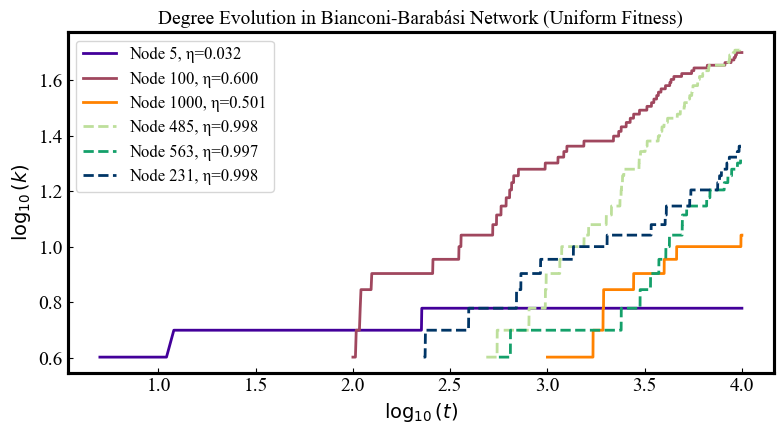

In [280]:
# Plot degree evolution for uniform fitness nodes
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

colors = ['#43009a', '#a0475e', '#ff8200']
colors_fitness = ['#BDDF9B', '#14A06A', '#003566']  # Teal/blue shades for high fitness nodes

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)
ax = fig.add_subplot(axgrid[0, 0])

# Plot initial nodes (indices 0, 1, 2)
for idx, ti in enumerate(tinitials_uniform):
    if len(log_t_uniform_list[idx]) > 0:
        node_id = all_node_ids[idx]
        fitness = all_fitness_values[idx]
        ax.plot(log_t_uniform_list[idx], log_k_uniform_list[idx], color=colors[idx % len(colors)], 
                linestyle='-', linewidth=2, alpha=1, label=f'Node {node_id}, η={fitness:.3f}')

# Plot high fitness nodes added after tpick (indices 3, 4, 5)
for idx in range(len(tinitials_uniform), len(tinitials_uniform) + 3):
    if len(log_t_uniform_list[idx]) > 0:
        fitness_idx = idx - len(tinitials_uniform)
        node_id = all_node_ids[idx]
        fitness = all_fitness_values[idx]
        ax.plot(log_t_uniform_list[idx], log_k_uniform_list[idx], color=colors_fitness[fitness_idx], 
                linestyle='--', linewidth=2, alpha=1, label=f'Node {node_id}, η={fitness:.3f}')

ax.set_title("Degree Evolution in Bianconi-Barabási Network (Uniform Fitness)")
ax.set_ylabel(r"$\log_{10}(k)$")
ax.set_xlabel(r"$\log_{10}(t)$")

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

ax.legend()
fig.tight_layout()
plt.savefig('a2_problem_3_d1.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [281]:
def FollowGenBBSpike(tinitials, tpickmin, tpickmax, tmax, m):
    G = nx.complete_graph(m)
    for node in G.nodes():
        G.nodes[node]['fitness'] = 0.1 if np.random.random() < 0.9 else 0.9
    t = m+1
    
    tlist_list = [[] for _ in range(len(tinitials) + 3)]
    klist_list = [[] for _ in range(len(tinitials) + 3)]
    
    top_fitness_nodes = []
    node_to_list_idx = {}  # Map node_id to its tracking list index
    
    while t <= tmax:
        degrees_from_G = list(G.degree())
        fitness_from_G = list(nx.get_node_attributes(G, 'fitness').values())
        available_nodes = [t[0] for t in degrees_from_G]
        available_fitness_degrees = [ fitness_from_G[i] * t[1] for i, t in enumerate(degrees_from_G)]
        G.add_node(t)
        new_fitness = 0.1 if np.random.random() < 0.9 else 0.9
        G.nodes[t]['fitness'] = new_fitness
        
        # Track highest fitness nodes added between tpickmin and tpickmax
        if tpickmin <= t <= tpickmax:
            if len(top_fitness_nodes) < 3:
                # Add new node and assign it to the next available slot
                slot_idx = len(top_fitness_nodes)
                top_fitness_nodes.append((t, new_fitness))
                node_to_list_idx[t] = len(tinitials) + slot_idx
                top_fitness_nodes.sort(key=lambda x: x[1], reverse=True)
            elif new_fitness > top_fitness_nodes[-1][1]:
                # Replace the lowest fitness node
                old_node_id = top_fitness_nodes[-1][0]
                old_list_idx = node_to_list_idx[old_node_id]
                
                # Clear the old node's data and remove its mapping
                tlist_list[old_list_idx] = []
                klist_list[old_list_idx] = []
                del node_to_list_idx[old_node_id]
                
                # Add new node, reusing the same list index
                top_fitness_nodes[-1] = (t, new_fitness)
                node_to_list_idx[t] = old_list_idx
                top_fitness_nodes.sort(key=lambda x: x[1], reverse=True)
        
        for _ in range(m):
            total_fitness_degree = sum(fitness_degrees for fitness_degrees in available_fitness_degrees)
            probabilities = [fitness_degrees/total_fitness_degree for fitness_degrees in available_fitness_degrees]
            nodes_positions = list(range(len(available_nodes)))
            chosen_position = np.random.choice(nodes_positions, p = probabilities)
            G.add_edge(t, available_nodes[chosen_position])
            available_nodes.pop(chosen_position)
            available_fitness_degrees.pop(chosen_position)
        
        for idx, tinitial in enumerate(tinitials):
            if t >= tinitial:
                tlist_list[idx].append(t)
                klist_list[idx].append(G.degree(tinitial))
        
        for idx, (node_id, fitness) in enumerate(top_fitness_nodes):
            if t >= node_id:
                list_idx = node_to_list_idx[node_id]
                tlist_list[list_idx].append(t)
                klist_list[list_idx].append(G.degree(node_id))
        
        t += 1
    
    
    all_node_ids = []
    all_fitness_values = []
    
    # Indices 0-2: Initial nodes
    for tinitial in tinitials:
        all_node_ids.append(tinitial)
        all_fitness_values.append(G.nodes[tinitial]['fitness'])
    
    # Indices 3-5: High fitness nodes - must match the order of their list indices!
    # Create a list to store (list_idx, node_id, fitness) for high fitness nodes
    high_fitness_info = []
    for node_id, fitness in top_fitness_nodes:
        list_idx = node_to_list_idx[node_id]
        high_fitness_info.append((list_idx, node_id, fitness))
    
    # Sort by list_idx to match the order in tlist_list and klist_list
    high_fitness_info.sort(key=lambda x: x[0])
    
    # Add to all_node_ids and all_fitness_values in the correct order
    for list_idx, node_id, fitness in high_fitness_info:
        all_node_ids.append(node_id)
        all_fitness_values.append(fitness)
    
    return tlist_list, klist_list, all_node_ids, all_fitness_values

In [286]:
tinitials_spike = [5, 100, 1000]
tpickmin = 100
tpickmax = 1000

tmax = 10000
m = 4

tlist_list_spike, klist_list_spike, all_node_ids_spike, all_fitness_values_spike = FollowGenBBSpike(tinitials_spike, tpickmin, tpickmax, tmax, m)

log_t_spike_list = []
log_k_spike_list = []

for idx in range(len(tinitials_spike) + 3):
    times = tlist_list_spike[idx]
    degrees = klist_list_spike[idx]
    if len(times) > 0:  # Only process if node has data
        log_t = [np.log10(t) for t in times]
        log_k = [np.log10(k) if k > 0 else np.nan for k in degrees]
        log_t_spike_list.append(log_t)
        log_k_spike_list.append(log_k)
    else:
        log_t_spike_list.append([])
        log_k_spike_list.append([])

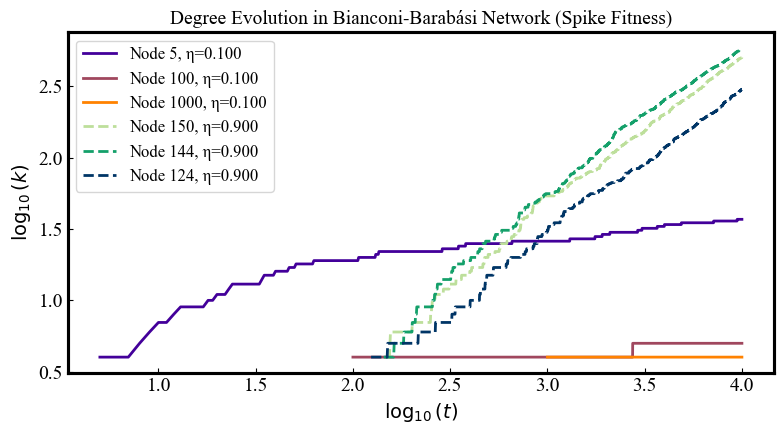

In [287]:
# Plot degree evolution for spike fitness nodes
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

colors = ['#43009a', '#a0475e', '#ff8200']
colors_fitness = ['#BDDF9B', '#14A06A', '#003566']  # Teal/blue shades for high fitness nodes

fig = plt.figure("", figsize=(16/2, 9/2))
axgrid = fig.add_gridspec(1, 1)
ax = fig.add_subplot(axgrid[0, 0])

# Plot initial nodes (indices 0, 1, 2)
for idx, ti in enumerate(tinitials_spike):
    if len(log_t_spike_list[idx]) > 0:
        node_id = all_node_ids_spike[idx]
        fitness = all_fitness_values_spike[idx]
        ax.plot(log_t_spike_list[idx], log_k_spike_list[idx], color=colors[idx % len(colors)], 
                linestyle='-', linewidth=2, alpha=1, label=f'Node {node_id}, η={fitness:.3f}')

# Plot high fitness nodes added after tpick (indices 3, 4, 5)
for idx in range(len(tinitials_spike), len(tinitials_spike) + 3):
    if len(log_t_spike_list[idx]) > 0:
        fitness_idx = idx - len(tinitials_spike)
        node_id = all_node_ids_spike[idx]
        fitness = all_fitness_values_spike[idx]
        ax.plot(log_t_spike_list[idx], log_k_spike_list[idx], color=colors_fitness[fitness_idx], 
                linestyle='--', linewidth=2, alpha=1, label=f'Node {node_id}, η={fitness:.3f}')

ax.set_title("Degree Evolution in Bianconi-Barabási Network (Spike Fitness)")
ax.set_ylabel(r"$\log_{10}(k)$")
ax.set_xlabel(r"$\log_{10}(t)$")

for spine in ax.spines.values():
    spine.set_linewidth(2.25)

ax.tick_params(direction='in', which='both')

ax.legend()
fig.tight_layout()
plt.savefig('a2_problem_3_d2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Problem 4

In [353]:
def GenOptimization(N, delta):
    G = nx.empty_graph()
    G.add_node(0)
    G.nodes[0]['x_position'] = np.random.uniform(0, 1)
    G.nodes[0]['y_position'] = np.random.uniform(0, 1)
    G.nodes[0]['resources'] = 0
    t = 1
    while t < N:
        G.add_node(t)
        G.nodes[t]['x_position'] = np.random.uniform(0, 1)
        G.nodes[t]['y_position'] = np.random.uniform(0, 1)
        costs = []
        for node in G.nodes():
            if node != t:
                x_diff = G.nodes[t]['x_position'] - G.nodes[node]['x_position']
                y_diff = G.nodes[t]['y_position'] - G.nodes[node]['y_position']
                distance = np.sqrt(x_diff**2 + y_diff**2)
                resource = G.nodes[node]['resources']
                cost = distance * delta + resource
                costs.append((node, cost))
        costs.sort(key=lambda x: x[1])
        chosen_node = costs[0][0]
        G.add_edge(t, chosen_node)
        G.nodes[t]['resources'] = G.nodes[chosen_node]['resources'] + 1
        t += 1
            
    return G

In [354]:
Gsmall = GenOptimization(10000, 0.1)
Gmed = GenOptimization(10000, 10)
Gbig = GenOptimization(10000, 1000)

In [355]:
Gsmall_degrees, Gsmall_probabilities = CalcDegreeDistribution(Gsmall)
Gmed_degrees, Gmed_probabilities = CalcDegreeDistribution(Gmed)
Gbig_degrees, Gbig_probabilities = CalcDegreeDistribution(Gbig)

In [356]:
bin_base_size = np.pow(10, 1/10)

Gsmall_bin_degrees, Gsmall_bin_probabilities = LogBinDegreeDistribution(Gsmall_degrees, Gsmall_probabilities, bin_base=bin_base_size)
Gmed_bin_degrees, Gmed_bin_probabilities = LogBinDegreeDistribution(Gmed_degrees, Gmed_probabilities, bin_base=bin_base_size)
Gbig_bin_degrees, Gbig_bin_probabilities = LogBinDegreeDistribution(Gbig_degrees, Gbig_probabilities, bin_base=bin_base_size)

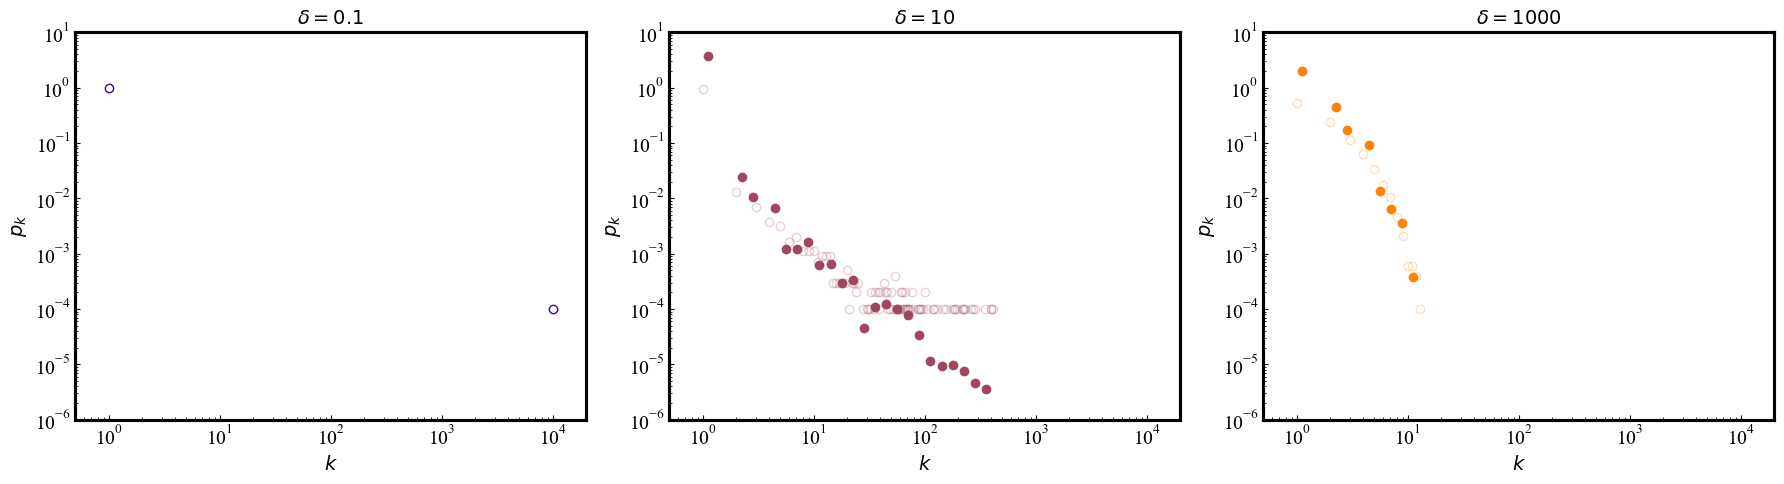

In [393]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig = plt.figure("", figsize=(18, 5))
axgrid = fig.add_gridspec(1, 3)

colors = ['#43009a', '#a0475e', '#ff8200']

xmin = 0.5
xmax = 20000
ymin = 0.000001
ymax = 10


# Plot Gsmall
ax1 = fig.add_subplot(axgrid[0, 0])
# Unbinned data (solid)
ax1.loglog(Gsmall_degrees, Gsmall_probabilities, color=colors[0], marker="o", linestyle='None', 
         markerfacecolor='none', markeredgecolor=colors[0], alpha=1)
ax1.set_title(r"$\delta = 0.1$")
ax1.set_ylabel(r"$p_{k}$")
ax1.set_xlabel(r"$k$")
for spine in ax1.spines.values():
    spine.set_linewidth(2.25)
ax1.tick_params(direction='in', which='both')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# Plot Gmed
ax2 = fig.add_subplot(axgrid[0, 1])
ax2.loglog(Gmed_degrees, Gmed_probabilities, color=colors[1], marker="o", linestyle='None', 
         markerfacecolor='none', markeredgecolor=colors[1], alpha=0.25)
# Binned data (solid)
ax2.loglog(Gmed_bin_degrees, Gmed_bin_probabilities, color=colors[1], marker="o", linestyle='None', 
         markerfacecolor=colors[1], markeredgecolor=colors[1], alpha=1)
ax2.set_title(r"$\delta = 10$")
ax2.set_ylabel(r"$p_{k}$")
ax2.set_xlabel(r"$k$")
for spine in ax2.spines.values():
    spine.set_linewidth(2.25)
ax2.tick_params(direction='in', which='both')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)

# Plot Gbig
ax3 = fig.add_subplot(axgrid[0, 2])
# Unbinned data (semi-transparent)
ax3.loglog(Gbig_degrees, Gbig_probabilities, color=colors[2], marker="o", linestyle='None', 
         markerfacecolor='none', markeredgecolor=colors[2], alpha=0.25)
# Binned data (solid)
ax3.loglog(Gbig_bin_degrees, Gbig_bin_probabilities, color=colors[2], marker="o", linestyle='None', 
         markerfacecolor=colors[2], markeredgecolor=colors[2], alpha=1)
ax3.set_title(r"$\delta = 1000$")
ax3.set_ylabel(r"$p_{k}$")
ax3.set_xlabel(r"$k$")
for spine in ax3.spines.values():
    spine.set_linewidth(2.25)
ax3.tick_params(direction='in', which='both')
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)



fig.tight_layout()

plt.savefig('a2_problem_4_b1.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [381]:
Gsmall2 = GenOptimization(1000, 0.1)
Gmed2 = GenOptimization(1000, 10)
Gbig2 = GenOptimization(1000, 1000)

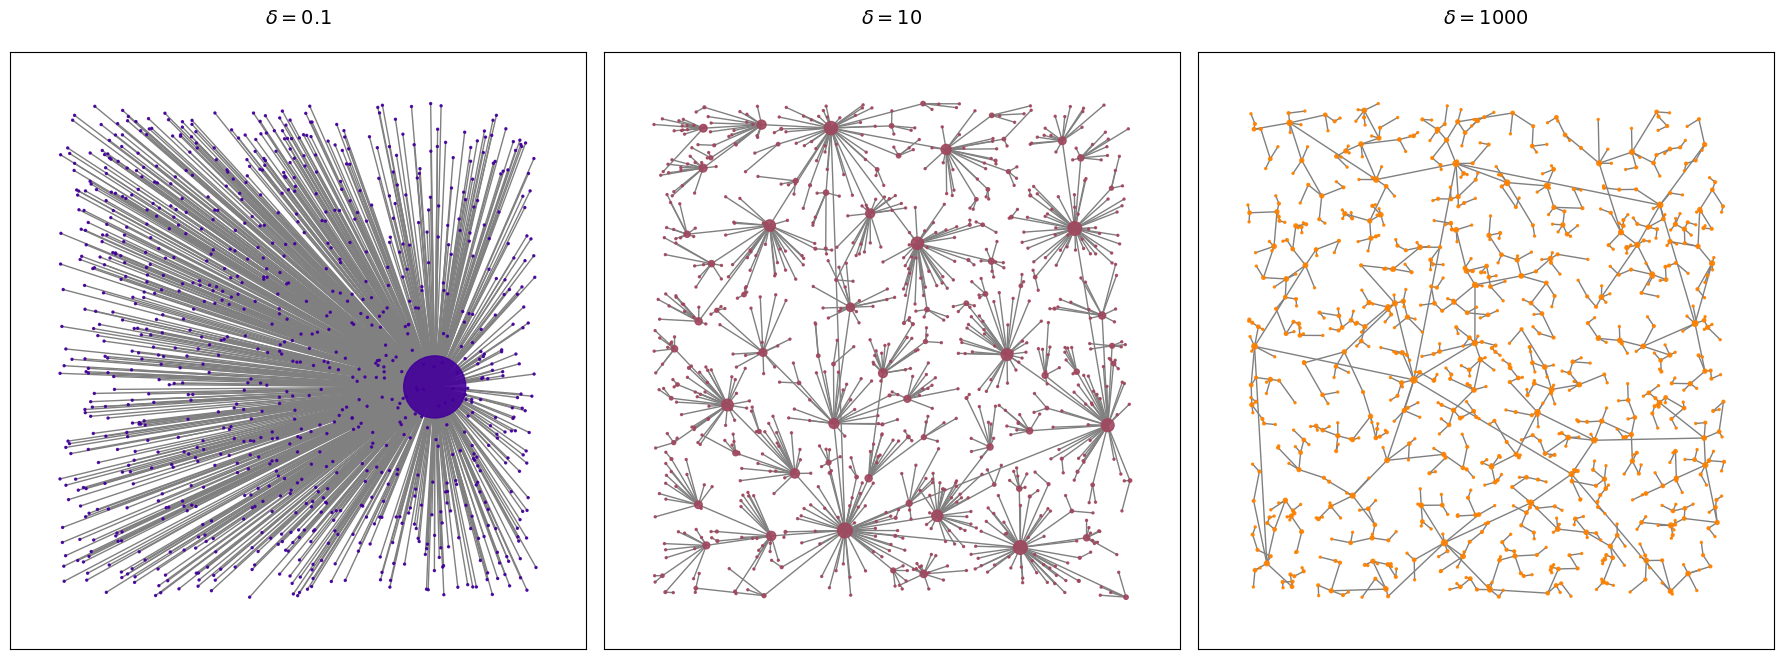

In [395]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(18, 6.75))
axgrid = fig.add_gridspec(1, 3)

colors = ['#43009a', '#a0475e', '#ff8200']

# Plot Gsmall2
ax1 = fig.add_subplot(axgrid[0, 0])
pos_small = {node: (Gsmall2.nodes[node]['x_position'], Gsmall2.nodes[node]['y_position']) 
             for node in Gsmall2.nodes()}
degrees_small = dict(Gsmall2.degree())
node_sizes_small = [degrees_small[node] * 2 for node in Gsmall2.nodes()]

nx.draw_networkx_edges(Gsmall2, pos_small, 
                       alpha=1,
                       width=1.0,
                       edge_color='gray',
                       ax=ax1)
nx.draw_networkx_nodes(Gsmall2, pos_small, 
                       node_color=colors[0],
                       node_size=node_sizes_small,
                       alpha=0.9,
                       ax=ax1)
ax1.set_title(r'$\delta = 0.1$', fontsize=14, pad=20)

# Plot Gmed2
ax2 = fig.add_subplot(axgrid[0, 1])
pos_med = {node: (Gmed2.nodes[node]['x_position'], Gmed2.nodes[node]['y_position']) 
           for node in Gmed2.nodes()}
degrees_med = dict(Gmed2.degree())
node_sizes_med = [degrees_med[node] * 2 for node in Gmed2.nodes()]

nx.draw_networkx_edges(Gmed2, pos_med, 
                       alpha=1,
                       width=1.0,
                       edge_color='gray',
                       ax=ax2)
nx.draw_networkx_nodes(Gmed2, pos_med, 
                       node_color=colors[1],
                       node_size=node_sizes_med,
                       alpha=0.9,
                       ax=ax2)
ax2.set_title(r'$\delta = 10$', fontsize=14, pad=20)

# Plot Gbig2
ax3 = fig.add_subplot(axgrid[0, 2])
pos_big = {node: (Gbig2.nodes[node]['x_position'], Gbig2.nodes[node]['y_position']) 
           for node in Gbig2.nodes()}
degrees_big = dict(Gbig2.degree())
node_sizes_big = [degrees_big[node] * 2 for node in Gbig2.nodes()]

nx.draw_networkx_edges(Gbig2, pos_big, 
                       alpha=1,
                       width=1.0,
                       edge_color='gray',
                       ax=ax3)
nx.draw_networkx_nodes(Gbig2, pos_big, 
                       node_color=colors[2],
                       node_size=node_sizes_big,
                       alpha=0.9,
                       ax=ax3)
ax3.set_title(r'$\delta = 1000$', fontsize=14, pad=20)

plt.tight_layout()

plt.savefig('a2_problem_4_b2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [464]:
def GenLinkSelection(N):
    G = nx.complete_graph(2)
    t = 2
    while t < N:
        G.add_node(t)
        links = list(G.edges())
        chosen_link = links[np.random.choice(len(links))]
        chosen_node = np.random.choice(chosen_link)
        G.add_edge(t, chosen_node)
        t += 1
            
    return G


In [465]:
def GenCopying(N, p):
    G = nx.DiGraph()
    G.add_edge(0, 1)
    G.add_edge(1, 0)
    t = 2
    while t < N:
        G.add_node(t)
        reference_node = np.random.choice(list(G.nodes()))
        if np.random.random() < p:
            chosen_node = reference_node
        else:
            neighbors = list(G.neighbors(reference_node))
            if len(neighbors) == 0:
                chosen_node = reference_node
            else:
                chosen_node = np.random.choice(neighbors)
        G.add_edge(t, chosen_node)
        t += 1
            
    return G

In [466]:
def TestPreferentialBA(N, iterations):
    G = GenBA(N, 1)
    
    # Track selection count for each individual node
    node_selection_count = {node: 0 for node in G.nodes()}
    
    degrees_from_G = list(G.degree())
    available_nodes = [t[0] for t in degrees_from_G]
    available_degrees = [t[1] for t in degrees_from_G]
    total_degree = sum(degrees for degrees in available_degrees)
    probabilities = [degree/total_degree for degree in available_degrees]
    nodes_positions = list(range(len(available_nodes)))
    
    for _ in range(iterations):
        chosen_position = np.random.choice(nodes_positions, p = probabilities)
        chosen_node = available_nodes[chosen_position]
        node_selection_count[chosen_node] += 1
    
    # Normalize to get Π(k_i) for each node
    Pi_ki = {node: count / iterations for node, count in node_selection_count.items()}
    
    # Prepare output: degrees and corresponding Π(k_i) for each node
    degrees_list = [G.degree(node) for node in G.nodes()]
    pis_list = [Pi_ki[node] for node in G.nodes()]
    
    return degrees_list, pis_list

In [467]:
TestPreferentialBA_degrees_list, TestPreferentialBA_pis_list = TestPreferentialBA(10000, 10000)

In [468]:
def TestPreferentialOptimization(N, delta, iterations):
    G = GenOptimization(N, delta)
    
    # Track selection count for each individual node
    node_selection_count = {node: 0 for node in G.nodes()}
    
    for _ in range(iterations):
        x_pos = np.random.uniform(0, 1)
        y_pos = np.random.uniform(0, 1)
        costs = []
        for node in G.nodes():
            x_diff = x_pos - G.nodes[node]['x_position']
            y_diff = y_pos - G.nodes[node]['y_position']
            distance = np.sqrt(x_diff**2 + y_diff**2)
            resource = G.nodes[node]['resources']
            cost = distance * delta + resource
            costs.append((node, cost))
        costs.sort(key=lambda x: x[1])
        chosen_node = costs[0][0]
        node_selection_count[chosen_node] += 1

    # Normalize to get Π(k_i) for each node
    Pi_ki = {node: count / iterations for node, count in node_selection_count.items()}
    
    # Prepare output: degrees and corresponding Π(k_i) for each node
    degrees_list = [G.degree(node) for node in G.nodes()]
    pis_list = [Pi_ki[node] for node in G.nodes()]
    
    return degrees_list, pis_list

In [469]:
TestPreferentialOptimization_degrees_list, TestPreferentialOptimization_pis_list = TestPreferentialOptimization(10000, 10, 10000)

In [470]:
def TestPreferentialLinkSelection(N, iterations):
    G = GenLinkSelection(N)
    
    # Track selection count for each individual node
    node_selection_count = {node: 0 for node in G.nodes()}
    
    links = list(G.edges())
    for _ in range(iterations):
        chosen_link = links[np.random.choice(len(links))]
        chosen_node = np.random.choice(chosen_link)
        node_selection_count[chosen_node] += 1

    # Normalize to get Π(k_i) for each node
    Pi_ki = {node: count / iterations for node, count in node_selection_count.items()}
    
    # Prepare output: degrees and corresponding Π(k_i) for each node
    degrees_list = [G.degree(node) for node in G.nodes()]
    pis_list = [Pi_ki[node] for node in G.nodes()]
    
    return degrees_list, pis_list

In [471]:
TestPreferentialLinkSelection_degrees_list, TestPreferentialLinkSelection_pis_list = TestPreferentialLinkSelection(10000, 10000)

In [472]:
def TestPreferentialCopying(N, p, iterations):
    G = GenCopying(N, p)
    
    # Track selection count for each individual node
    node_selection_count = {node: 0 for node in G.nodes()}
    
    node_list = list(G.nodes())
    for _ in range(iterations):
        reference_node = np.random.choice(node_list)
        if np.random.random() < p:
            chosen_node = reference_node
        else:
            neighbors = list(G.neighbors(reference_node))
            if len(neighbors) == 0:
                chosen_node = reference_node
            else:
                chosen_node = np.random.choice(neighbors)
        
        node_selection_count[chosen_node] += 1

    # Normalize to get Π(k_i) for each node
    Pi_ki = {node: count / iterations for node, count in node_selection_count.items()}
    
    # Prepare output: degrees and corresponding Π(k_i) for each node
    degrees_list = [G.degree(node) for node in G.nodes()]
    pis_list = [Pi_ki[node] for node in G.nodes()]
    
    return degrees_list, pis_list

In [473]:
TestPreferentialCopying_degrees_list, TestPreferentialCopying_pis_list = TestPreferentialCopying(10000, 0.5, 10000)

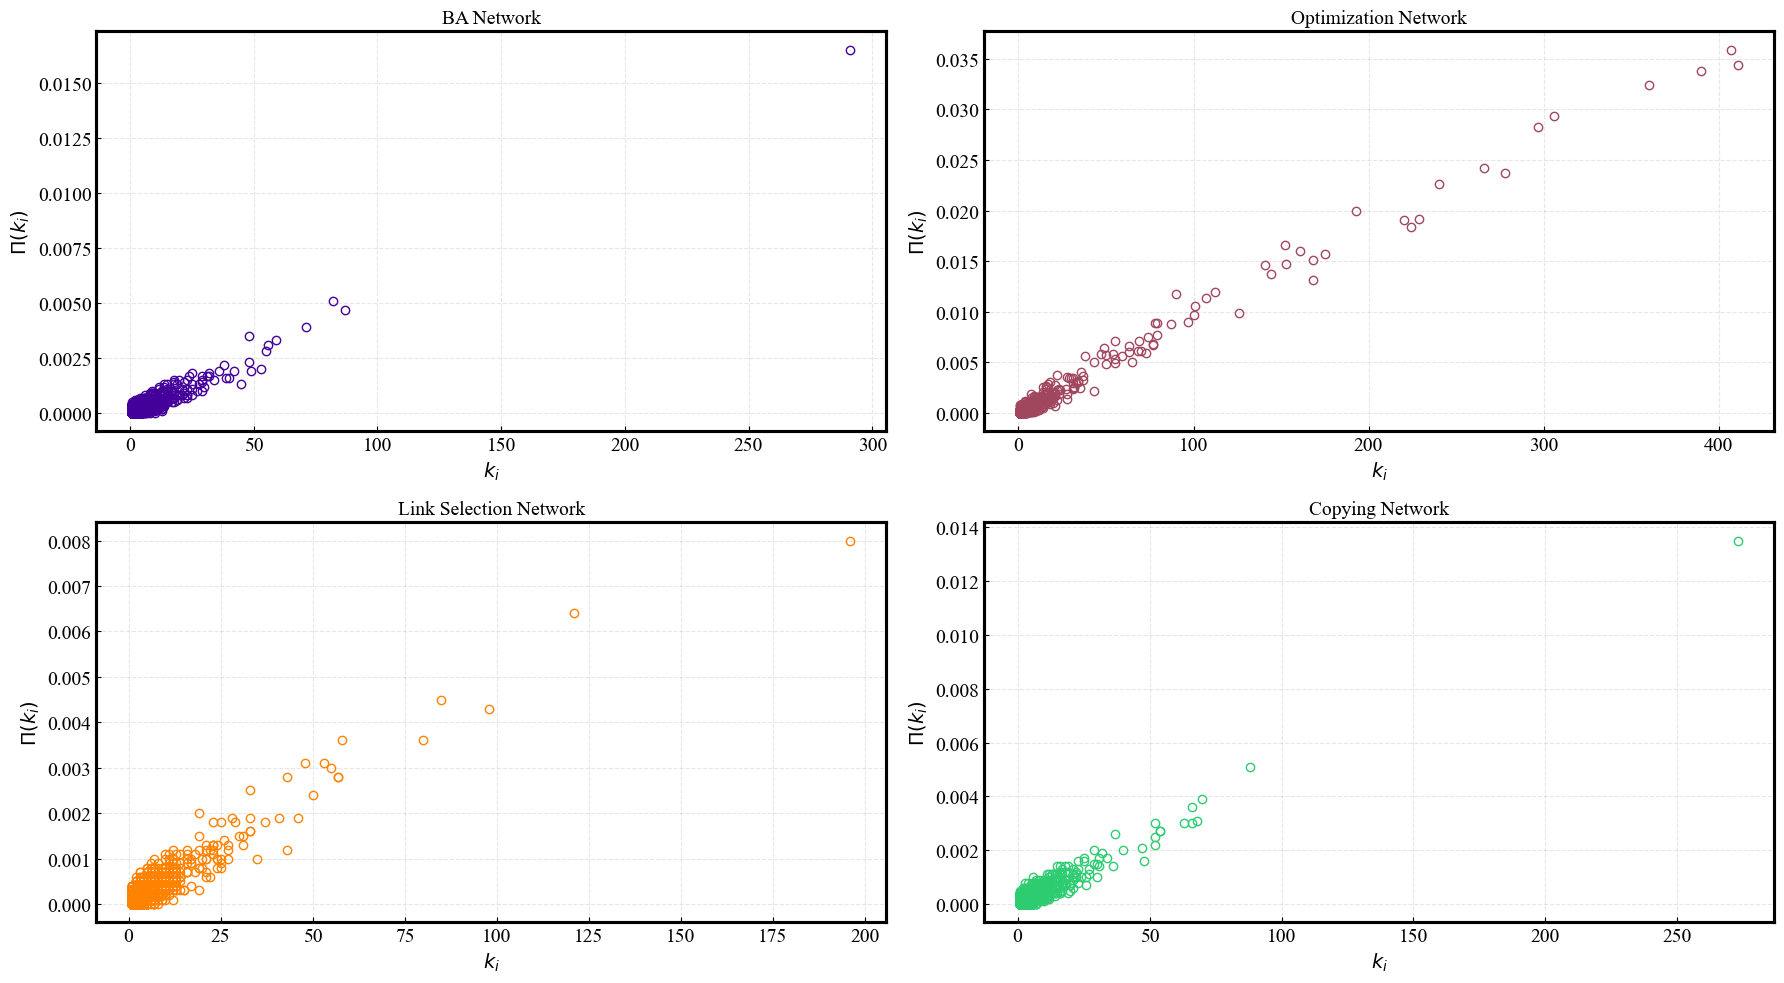

In [476]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig = plt.figure("", figsize=(18, 10))
axgrid = fig.add_gridspec(2, 2)

colors = ['#43009a', '#a0475e', '#ff8200', '#2ecc71']

# Plot BA
ax1 = fig.add_subplot(axgrid[0, 0])
ax1.plot(TestPreferentialBA_degrees_list, TestPreferentialBA_pis_list, 
          color=colors[0], marker="o", linestyle='None', 
          markerfacecolor='none', markeredgecolor=colors[0], alpha=1)
ax1.set_title("BA Network")
ax1.set_ylabel(r"$\Pi(k_{i})$")
ax1.set_xlabel(r"$k_{i}$")
for spine in ax1.spines.values():
    spine.set_linewidth(2.25)
ax1.tick_params(direction='in', which='both')
ax1.grid(True, which='both', alpha=0.3, linestyle='--')

# Plot Optimization
ax2 = fig.add_subplot(axgrid[0, 1])
ax2.plot(TestPreferentialOptimization_degrees_list, TestPreferentialOptimization_pis_list, 
          color=colors[1], marker="o", linestyle='None', 
          markerfacecolor='none', markeredgecolor=colors[1], alpha=1)
ax2.set_title("Optimization Network")
ax2.set_ylabel(r"$\Pi(k_{i})$")
ax2.set_xlabel(r"$k_{i}$")
for spine in ax2.spines.values():
    spine.set_linewidth(2.25)
ax2.tick_params(direction='in', which='both')
ax2.grid(True, which='both', alpha=0.3, linestyle='--')

# Plot Link Selection
ax3 = fig.add_subplot(axgrid[1, 0])
ax3.plot(TestPreferentialLinkSelection_degrees_list, TestPreferentialLinkSelection_pis_list, 
          color=colors[2], marker="o", linestyle='None', 
          markerfacecolor='none', markeredgecolor=colors[2], alpha=1)
ax3.set_title("Link Selection Network")
ax3.set_ylabel(r"$\Pi(k_{i})$")
ax3.set_xlabel(r"$k_{i}$")
for spine in ax3.spines.values():
    spine.set_linewidth(2.25)
ax3.tick_params(direction='in', which='both')
ax3.grid(True, which='both', alpha=0.3, linestyle='--')

# Plot Copying
ax4 = fig.add_subplot(axgrid[1, 1])
ax4.plot(TestPreferentialCopying_degrees_list, TestPreferentialCopying_pis_list, 
          color=colors[3], marker="o", linestyle='None', 
          markerfacecolor='none', markeredgecolor=colors[3], alpha=1)
ax4.set_title("Copying Network")
ax4.set_ylabel(r"$\Pi(k_{i})$")
ax4.set_xlabel(r"$k_{i}$")
for spine in ax4.spines.values():
    spine.set_linewidth(2.25)
ax4.tick_params(direction='in', which='both')
ax4.grid(True, which='both', alpha=0.3, linestyle='--')

fig.tight_layout()
plt.savefig('a2_problem_4_d.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()